**NB**: Я перезаписала базу данных так, что её объём стал больше.

Кроме того, теперь в ней есть отдельная колонка, в которой записаны все использованные в посте (если быть точнее, в его очищенном варианте) части речи (т. е. для фразы *Мама мыла раму* будет `NOUN VERB NOUN`).

*Гипотеза*

С популярностью поста (т. е. числом лайков) связаны:
1. Наиболее частотные слова;
2. Распределение частей речи.

In [1]:
import sqlite3
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from matplotlib import style
#style.use('ggplot')
from collections import OrderedDict
from wordcloud import WordCloud
from pprint import pprint
import random 
import pandas as pd

In [2]:
conn = sqlite3.connect('vk_4.db')
cur = conn.cursor()

<AxesSubplot:ylabel='Density'>

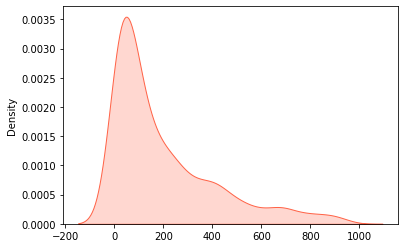

In [3]:
likes_query = """
SELECT likes
FROM posts
"""
cur.execute(likes_query)
likes = cur.fetchall()
my_likes = [i[0] for i in likes if i[0] <= 950]

sns.kdeplot(my_likes, shade=True, color="tomato")

Очевидно, что распределение совершенно не равномерное: намного больше постов с малым числом лайков.

Поэтому делим посты примерно так, чтобы было более-менее одинаково.

In [4]:
popular_text_query = """
SELECT post_lemmas
FROM posts
WHERE likes >= 310
"""
cur.execute(popular_text_query)
popular_text_data = cur.fetchall()

In [5]:
len(popular_text_data)

628

In [6]:
unpopular_text_query = """
SELECT post_lemmas
FROM posts
WHERE likes < 70
"""
cur.execute(unpopular_text_query)
un_popular_text_data = cur.fetchall()

In [7]:
len(un_popular_text_data)

598

In [8]:
medpopular_text_query = """
SELECT post_lemmas
FROM posts
WHERE likes < 310 AND 70 <= likes
"""
cur.execute(medpopular_text_query)
med_popular_text_data = cur.fetchall()

In [9]:
len(med_popular_text_data)

591

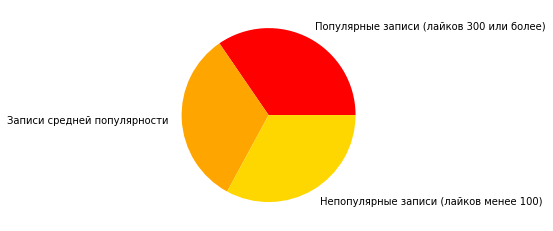

In [10]:
sizes = [len(popular_text_data),
         len(med_popular_text_data),
        len(un_popular_text_data),]
names = ['Популярные записи (лайков 300 или более)',
        'Записи средней популярности',
        'Непопулярные записи (лайков менее 100)']
my_colors = ['red',
            'orange',
            'gold']
plt.pie(sizes,
        labels=names,
        labeldistance=1.15,
        colors=my_colors)
plt.show()

В целом, такое распределение групп меня устраивает.

## Это функция, которая:

- определяет топ-15 слов в списке постов;
- делает частотный словарь всех слов (нужно, чтобы потом привести все списки частот к единому виду);
- считает, сколько слов всего (нужно, чтобы считать потом не абсолютную, а относительную частоту слова).

In [11]:
def pop_words(data):
    my_data = []
    bad_words = ['это', 'мой', 'который', 'свой', 'очень', 'все', 'быть', 'каждый', 'в', 
                'я', 'и', 'https', 'а']
    for i in data:
        words = [n for n in i[0].split(' ') if n not in bad_words and n.isalpha()]
        my_data.extend(words) 
    #print(my_data)
    c = Counter(my_data)
    cc = c.most_common(15)
    how_many = sum(c.values())
    #print(cc)
    return(c, cc, how_many)

In [12]:
p_totall, p_common, p_how_many = pop_words(popular_text_data)
u_totall, u_common, u_how_many = pop_words(un_popular_text_data)
m_totall, m_common, m_how_many = pop_words(med_popular_text_data)

## Эта функция:
 - пересчитывает частоты слов в проценты.

In [13]:
def new_dict(d_one, d_two, w, n):
    #print(len(d_one))
    if w in d_one.keys():
            d_two[w] = (d_one[w]/n)*100
    else:
        d_two[w] = 0
    return d_two

In [14]:
def many(one_t, one_c, one_m, two_t, two_c, two_m, three_t, three_c, three_m):
    s = []
    one_d = OrderedDict()
    two_d = OrderedDict()
    three_d = OrderedDict()
    one_v = [v[0] for v in one_c]
    two_v = [v[0] for v in two_c]
    three_v = [v[0] for v in three_c]
    s.extend(one_v)
    s.extend(two_v)
    s.extend(three_v)
    for key in s:
        one_d = new_dict(one_t, one_d, key, one_m)
        two_d = new_dict(two_t, two_d, key, two_m)
        three_d = new_dict(three_t, three_d, key, three_m)
    return one_d, two_d, three_d

In [15]:
p, u, m = many(p_totall, p_common, p_how_many, u_totall, u_common, u_how_many, m_totall, m_common, m_how_many)

([<matplotlib.axis.XTick at 0x1c4aebe0>,
 [Text(1, 0, 'год'),
  Text(5, 0, 'человек'),
  Text(9, 0, 'хотеть'),
  Text(13, 0, 'спасибо'),
  Text(17, 0, 'новый'),
  Text(21, 0, 'день'),
  Text(25, 0, 'мочь'),
  Text(29, 0, 'самый'),
  Text(33, 0, 'время'),
  Text(37, 0, 'вы'),
  Text(41, 0, 'канал'),
  Text(45, 0, 'просто'),
  Text(49, 0, 'друг'),
  Text(53, 0, 'этот'),
  Text(57, 0, 'видео'),
  Text(61, 0, 'ты'),
  Text(65, 0, 'весь'),
  Text(69, 0, 'жизнь'),
  Text(73, 0, 'сегодня'),
  Text(77, 0, 'хороший'),
  Text(81, 0, 'еще'),
  Text(85, 0, 'наш'),
  Text(89, 0, 'твой')])

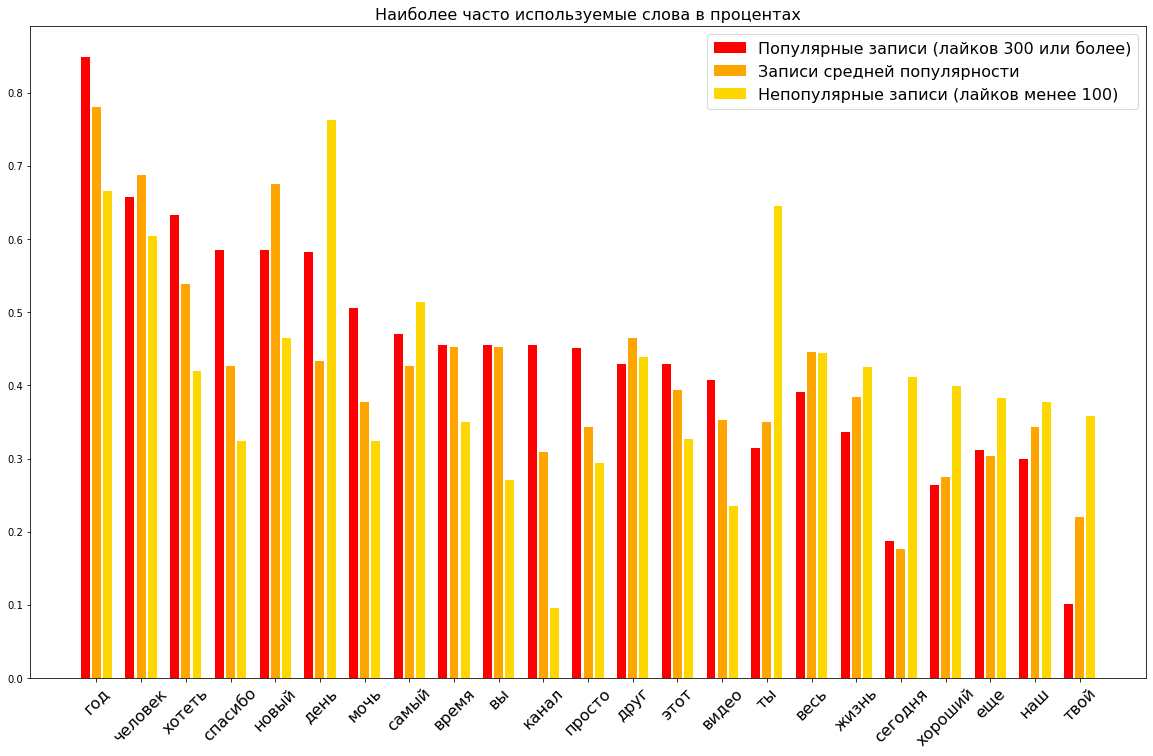

In [16]:
barWidth = 10
y_pos = [a*4 for a in range(len(p))]
y_pos_one = [y + 1 for y in y_pos]
y_pos_two = [y + 1 for y in y_pos_one]
plt.figure(figsize=(20,12))
plt.bar(y_pos, [w for w in p.values()], color='red', label = 'Популярные записи (лайков 300 или более)')
plt.bar(y_pos_one, [w for w in m.values()], color='orange', label = 'Записи средней популярности')
plt.bar(y_pos_two, [w for w in u.values()], color='gold', label = 'Непопулярные записи (лайков менее 100)')
plt.legend(fontsize = 16)
plt.title('Наиболее часто используемые слова в процентах', fontsize = 16)
plt.xticks(y_pos_one, [w for w in m.keys()], fontsize = 16, rotation = 45)

## Можно заметить, что:
- действительно, частоты слов связаны с популярностью постов.

Можно предположить, чем это вызвано в случае со словом *канал*: это посты каких-нибудь популярных блогеров, которые просят подписаться на канал, или рекламируют видео с канала, или ещё что-нибудь; из-за их поплуряности у них много подписчиков, которые лайкают из посты.

In [17]:
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(80, 100)

#def cloud(lemmas, my_title, bg, color):
def cloud(lemmas, my_title, bg):
    my_data = []
    bad_words = ['это', 'мой', 'который', 'свой', 'очень', 'все', 'быть', 'каждый', 'в', 
                'я', 'и', 'https', 'а']
    for i in lemmas:
        words = [n for n in i[0].split(' ') if n not in bad_words and n.isalpha()]
        my_data.extend(words) 
    text = ' '.join([word for word in my_data])
    wordcloud = WordCloud(
        background_color =bg,
        #colormap = color,
        width = 1500,
        height = 1500, 
    ).generate(text)
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
    #plt.imshow(wordcloud)
    plt.axis("off") 
    plt.title(my_title, fontsize = 16)
    plt.show()

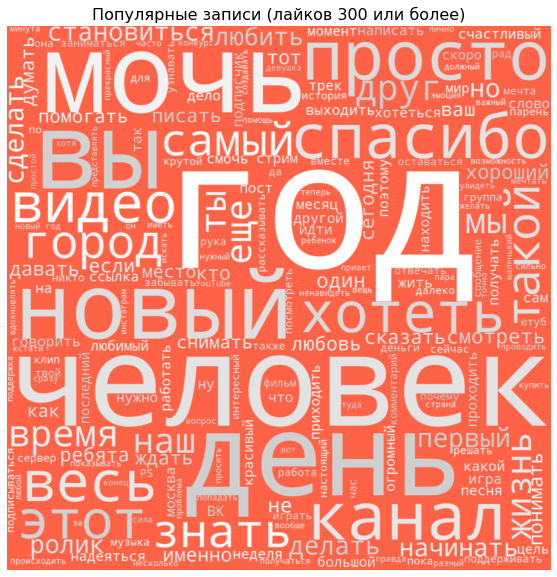

In [18]:
cloud(popular_text_data, 'Популярные записи (лайков 300 или более)', 'tomato')

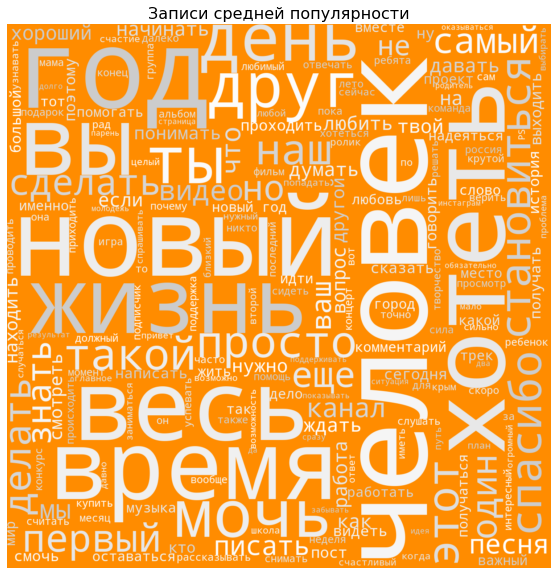

In [19]:
cloud(med_popular_text_data, 'Записи средней популярности', 'darkorange')

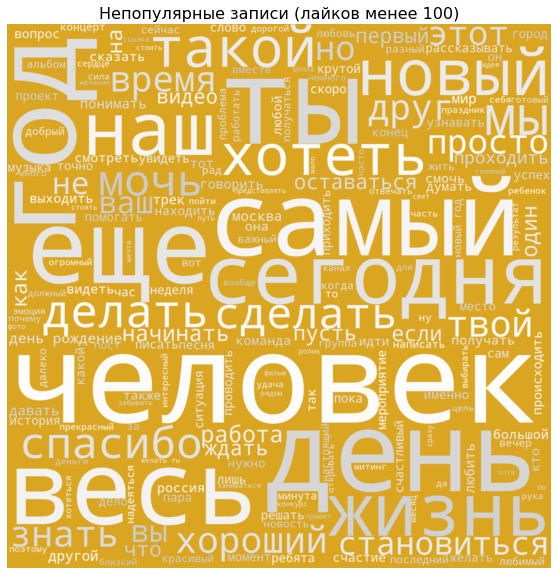

In [20]:
cloud(un_popular_text_data, 'Непопулярные записи (лайков менее 100)', 'goldenrod')

На облаках слов разница не заметна (хотя на первой картинке можно увидеть слово *канал*), потому что они малоинформативные, но они красивые, так что пусть останутся.

## Теперь всё то же самое, но для частей речи

(Части речи сразу добавлялись в базу данных).

([<matplotlib.axis.XTick at 0x1e44a160>,
 [Text(1, 0, 'NOUN'),
  Text(5, 0, 'VERB'),
  Text(9, 0, 'ADJF'),
  Text(13, 0, 'ADVB'),
  Text(17, 0, 'PRCL'),
  Text(21, 0, 'NPRO'),
  Text(25, 0, 'CONJ'),
  Text(29, 0, 'PREP'),
  Text(33, 0, 'INTJ'),
  Text(37, 0, 'ADJS'),
  Text(41, 0, 'PRED'),
  Text(45, 0, 'NUMR'),
  Text(49, 0, 'GRND'),
  Text(53, 0, 'PRTF'),
  Text(57, 0, 'PRTS')])

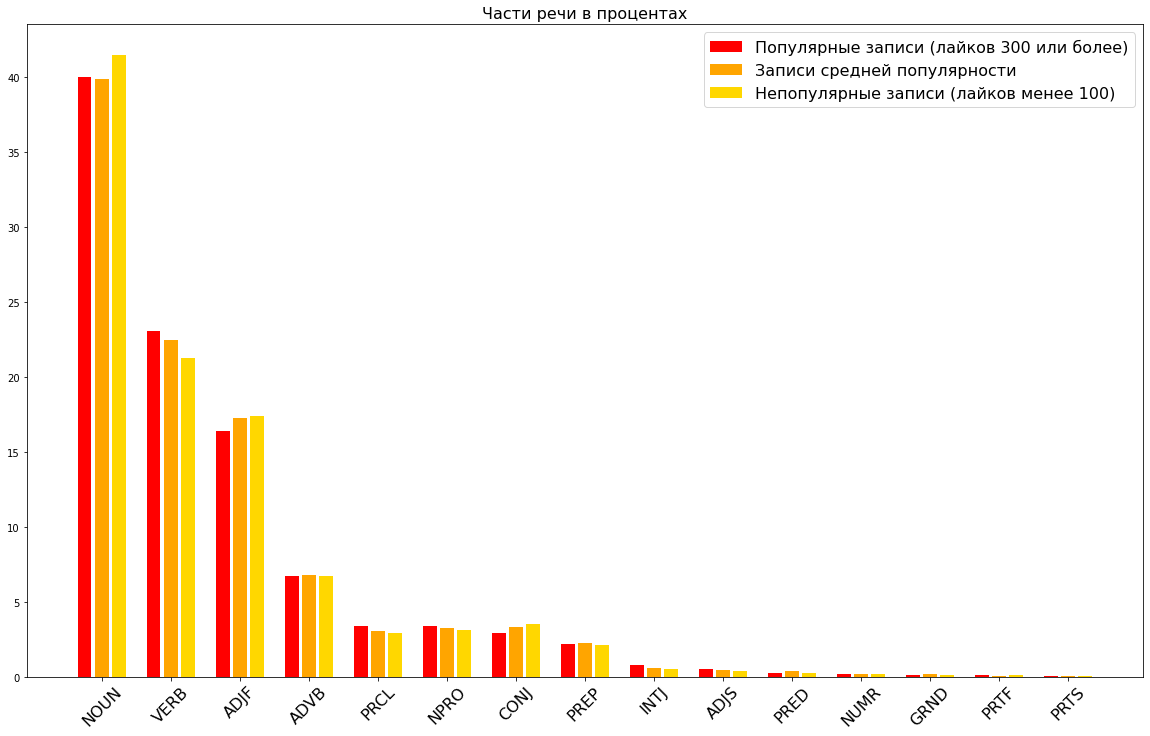

In [21]:
popular_pos_query = """
SELECT pos
FROM posts
WHERE likes >= 310
"""
cur.execute(popular_pos_query)
popular_pos_data = cur.fetchall()

unpopular_pos_query = """
SELECT pos
FROM posts
WHERE likes < 70
"""
cur.execute(unpopular_pos_query)
un_popular_pos_data = cur.fetchall()

medpopular_pos_query = """
SELECT pos
FROM posts
WHERE likes < 310 AND 70 <= likes
"""
cur.execute(medpopular_pos_query)
med_popular_pos_data = cur.fetchall()

p_totall, p_common, p_how_many = pop_words(popular_pos_data)
u_totall, u_common, u_how_many = pop_words(un_popular_pos_data)
m_totall, m_common, m_how_many = pop_words(med_popular_pos_data)

p, u, m = many(p_totall, p_common, p_how_many, u_totall, u_common, u_how_many, m_totall, m_common, m_how_many)

barWidth = 10
y_pos = [a*4 for a in range(len(p))]
y_pos_one = [y + 1 for y in y_pos]
y_pos_two = [y + 1 for y in y_pos_one]
plt.figure(figsize=(20,12))
plt.bar(y_pos, [w for w in p.values()], color='red', label = 'Популярные записи (лайков 300 или более)')
plt.bar(y_pos_one, [w for w in m.values()], color='orange', label = 'Записи средней популярности')
plt.bar(y_pos_two, [w for w in u.values()], color='gold', label = 'Непопулярные записи (лайков менее 100)')
plt.legend(fontsize = 16)
plt.title('Части речи в процентах', fontsize = 16)
plt.xticks(y_pos_one, [w for w in m.keys()], fontsize = 16, rotation = 45)

- Популярность и распределение частей речи не взаимосвязаны.

Что можно сказать по этому поводу?

Иногда распределение частей речи, действительно, может что-то сказать. Так, подобный же тест, проведённый на небольшом корпусе мемуаров, показал, что есть какая-то связь между автором и распределением частей речи.

<img src = https://raw.githubusercontent.com/YanaKoko/1812/main/пос_3.JPG>

(Обратите внимание на зелёные столбики существительных. Они намного ниже других).

Однако здесь мы имеем несколько иную ситуацию: части речи распределены примерно одинаково во всех трёх группах.

Впрочем, нет ничего удивительного, что так получилось: в собрании постов нет и не может быть никакого *авторского сигнала*, потому что от каждого пользователя получалось не более двадцати потсов.

# Выводы:

Гипотеза (1) подтвердилась, и даже можно найти ей некоторое подобие объяснения.

Гипотеза (2) не подтвердилась. Вероятно, так и должно было быть.